<a href="https://colab.research.google.com/github/Chygos/mlops-zoomcamp/blob/main/HomeWork1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/drive/MyDrive/mlzoomcamp

/content/drive/MyDrive/mlzoomcamp


In [6]:
%ls

data/  HM1.ipynb


In [7]:
%ls data/

yellow_tripdata_2022-01.parquet  yellow_tripdata_2022-02.parquet


In [4]:
!python -V

Python 3.10.11


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle
import seaborn as sns

## Question 1: Number of Columns in dataset (Jan data)

In [8]:
jan_data = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')

In [9]:
jan_data.shape

((2463931, 19), (2979431, 19))

__There are 19 columns in the January data__

In [10]:
jan_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [11]:
jan_data.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0


## Q2: Computing Duration (In minutes)

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [16]:
# Creating duration in minutes
jan_data = jan_data.assign(
    duration = (jan_data.tpep_dropoff_datetime - jan_data.tpep_pickup_datetime).dt.total_seconds() / 60
    )

In [17]:
jan_data.duration.std()

46.44530513776802

__The standard deviation of duration in the Jan data is 46.45__

## Q3: Dropping Outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [25]:
# length of jan_data before outlier removal
len_before = jan_data.shape[0]

In [26]:
jan_data = jan_data.query('duration.between(1,60)')
len_after  = jan_data.shape[0]

In [28]:
# percentage left after outlier removal
len_after / len_before * 100

98.27547930522405

__98% of the records were left after dropping outliers (duration above 60 minutes)__

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [29]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

jan_data[categorical] = jan_data[categorical].astype(str)

In [32]:
jan_data.shape

(2421440, 20)

In [40]:
train_dicts = jan_data[categorical].to_dict(orient='records')

In [43]:
vectoriser = DictVectorizer()
X_train = vectoriser.fit_transform(train_dicts)

In [44]:
len(vectoriser.feature_names_)

515

__The dimensionality of the matrix is 515__

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [45]:
# instantiating linear regression model
linreg = LinearRegression()

In [46]:
target = 'duration'
ytrain = jan_data[target]

In [47]:
linreg.fit(X_train, ytrain)

LinearRegression()

In [48]:
predictions = linreg.predict(X_train)

In [49]:
mean_squared_error(ytrain, predictions, squared=False)

6.986190742248472

RMSE on train data is 6.99

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

In [52]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df.query('duration.between(1,60)')

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [53]:
feb_data = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

<ipython-input-52-3e94497bc7a1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [56]:
# validation records
val_dicts = feb_data[categorical].to_dict(orient='records')

In [57]:
X_val = vectoriser.transform(val_dicts)

In [58]:
val_predictions = linreg.predict(X_val)

In [59]:
yval = feb_data[target]

In [60]:
mean_squared_error(yval, val_predictions, squared=False)

7.78640662117552

RMSE on validation data is 7.79

__Density Plots for Training and Validation data with their Predictions__

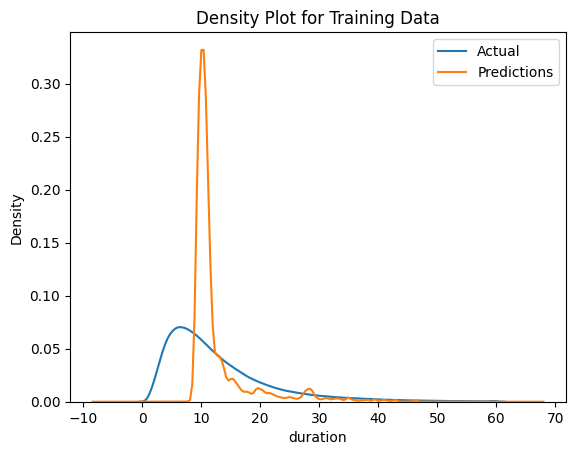

In [64]:
sns.kdeplot(ytrain, label='Actual')
sns.kdeplot(predictions, label='Predictions')
plt.title('Density Plot for Training Data')
plt.legend()
plt.show()

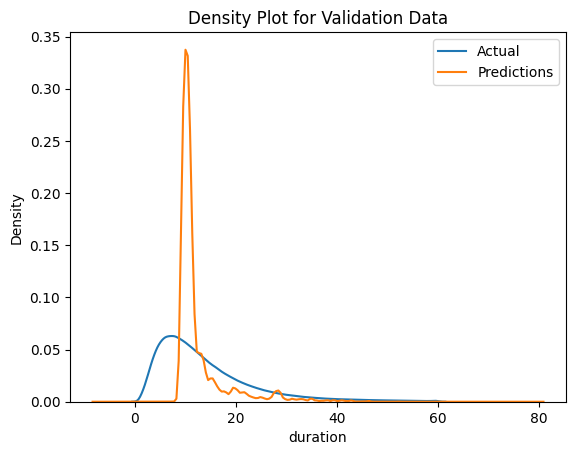

In [65]:
sns.kdeplot(yval, label='Actual')
sns.kdeplot(val_predictions, label='Predictions')
plt.title('Density Plot for Validation Data')
plt.legend()
plt.show()